In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors  
from matplotlib import cm # color maps

pd.core.common.random_state(None)
seed = 13       # to initiate random number generator
np.random.seed(seed)

#--- 

width = 2 
height = 1

In [2]:
#--- read data, create training and validation sets

url = "https://raw.githubusercontent.com/VincentGranville/Statistical-Optimization/main/karnataka_temperature_afternoon.csv"
# data = pd.read_csv('karnataka_temperature_afternoon.csv')
data = pd.read_csv(url)
data = data[['longitude', 'latitude','temperature']]
features = list(data.columns)
# print(features)
data_training = data.sample(frac = 0.5)
data_validation = data.drop(data_training.index)
data_training.to_csv('temperature_india_training_vg2.csv')
data_validation.to_csv('temperature_india_validation_vg2.csv')
# print(data_training)
# print(data_validation)
npdata = pd.DataFrame.to_numpy(data_training)
z = npdata[:,2]   # temperatures
n = len(z)
print("nobs_training:",n)

# locations for validation set
vld = pd.DataFrame.to_numpy(data_validation[['longitude','latitude','temperature']])
xa =  vld[:,0] 
ya =  vld[:,1] 
z_true = vld[:,2]
n_valid = len(xa)
print("nobs_validation:",n_valid)
# print(npdata) 

nobs_training: 112
nobs_validation: 111


In [3]:
#--- model parameters

alpha = 1.0       # small alpha increases smoothing
beta  = 2.0       # small beta increases smoothing
kappa = 2.0       # high kappa makes method close to kriging 
eps   = 1.0e-8    # make it work if sample locations same as observed ones
delta = eps + 1.2 * max(width, height)   # don't use faraway points for interpolation

In [4]:
#--- interpolation for validation set 

def w(x, y, x_k, y_k, alpha, beta):
    # distance function
    z = (abs(x - x_k)**beta + abs(y - y_k)**beta)**alpha
    return(z)

def interpolate(x, y, npdata, delta):

    # compute interpolated z at location (x, y) based on npdata (observations)
    # also returns npt, the number of data points used for each interpolated value
    # data points (x_k, y_k) with w[(x,y), (x_k,y_k)] >= delta are ignored
    # note: (x, y) can be a location or an array of locations

    if np.isscalar(x):  # transform scalar to 1-cell array
        x = [x]
        y = [y]
    sum  = np.zeros(len(x))
    sum_coeff = np.zeros(len(x)) 
    npt = np.zeros(len(x)) 
    
    for k in range(n):
        x_k = npdata[k, 0]
        y_k = npdata[k, 1]
        z_k = npdata[k, 2]
        coeff = 1
        for i in range(n):
            x_i = npdata[i, 0]
            y_i = npdata[i, 1]
            if i != k:
                numerator = w(x, y, x_i, y_i, alpha, beta)
                denominator = w(x_k, y_k, x_i, y_i, alpha, beta) 
                coeff *= numerator / (eps + denominator) 
        dist = w(x, y, x_k, y_k, alpha, beta)   
        coeff = (eps + dist)**(-kappa) * coeff / (1 + coeff) 
        coeff[dist > delta] = 0.0  
        sum_coeff += coeff
        npt[dist < delta] += 1   
        sum += z_k * coeff  
 
    z = sum / sum_coeff 
    return(z, npt)

(za, npt) = interpolate(xa, ya, npdata, 0.5*delta)

for k in range(n_valid):
    print("longitude: %6.3f    latitude: %6.3f    predicted temp.: %6.3f    real temp.: %6.3f" %(xa[k], ya[k], za[k], z_true[k]))

longitude: 75.700    latitude: 16.183    predicted temp.: 29.972    real temp.: 30.260
longitude: 75.300    latitude: 16.517    predicted temp.: 30.069    real temp.: 31.150
longitude: 77.314    latitude: 18.223    predicted temp.: 25.146    real temp.: 24.550
longitude: 75.677    latitude: 15.915    predicted temp.: 28.778    real temp.: 29.650
longitude: 75.619    latitude: 16.346    predicted temp.: 29.643    real temp.: 30.480
longitude: 75.173    latitude: 14.908    predicted temp.: 28.408    real temp.: 27.410
longitude: 76.133    latitude: 15.967    predicted temp.: 28.840    real temp.: 28.840
longitude: 76.617    latitude: 15.400    predicted temp.: 30.432    real temp.: 30.590
longitude: 74.586    latitude: 16.427    predicted temp.: 30.511    real temp.: 29.080
longitude: 74.384    latitude: 16.402    predicted temp.: 30.412    real temp.: 28.230
longitude: 75.118    latitude: 15.767    predicted temp.: 28.716    real temp.: 27.910
longitude: 74.723    latitude: 16.692    pr

In [5]:
#--- visualizations

nlevels = 20  # number of levels on contour plots

def set_plt_params():
    # initialize visualizations
    fig = plt.figure(figsize =(4, 3), dpi=200) 
    ax = fig.gca()
    plt.setp(ax.spines.values(), linewidth=0.1)
    ax.xaxis.set_tick_params(width=0.1)
    ax.yaxis.set_tick_params(width=0.1)
    ax.xaxis.set_tick_params(length=2)
    ax.yaxis.set_tick_params(length=2)
    ax.tick_params(axis='x', labelsize=4)
    ax.tick_params(axis='y', labelsize=4)
    plt.rc('xtick', labelsize=7) 
    plt.rc('ytick', labelsize=7) 
    plt.rcParams['axes.linewidth'] = 0.1
    return(fig,ax)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

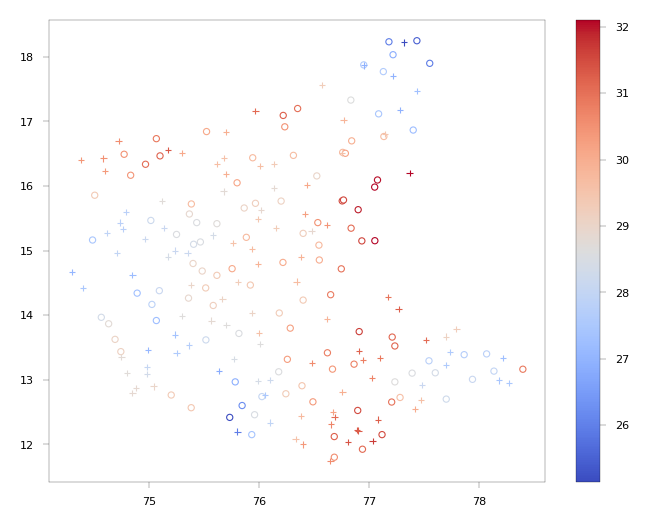

In [7]:
# scatter plot: validation set (+) and training data (o)         

(fig2, ax2) = set_plt_params()
my_cmap = mpl.colormaps['coolwarm']  # old version: cm.get_cmap('coolwarm')
my_norm = colors.Normalize()
ec_colors = my_cmap(my_norm(npdata[:,2]))
sc2a = plt.scatter(npdata[:,0], npdata[:,1], c='white', s=5, cmap=my_cmap, 
    edgecolors=ec_colors,linewidth=0.4)
sc2b = plt.scatter(xa, ya, c=za, cmap=my_cmap, marker='+',s=5,linewidth=0.4)
cbar1 = plt.colorbar(sc2b)
cbar1.ax.tick_params(width=0.1) 
cbar1.ax.tick_params(length=2) 
cbar1.ax.tick_params(labelsize=4)
plt.show()
## plt.close()

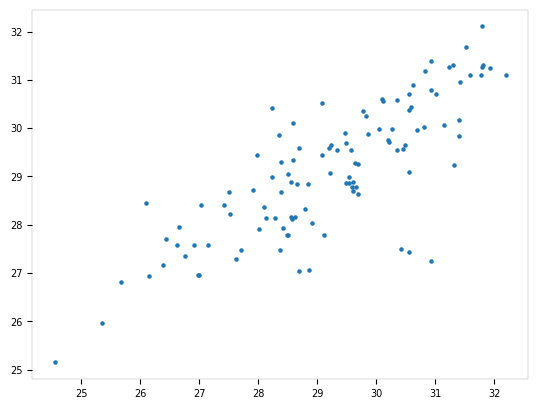

In [8]:
# temperature scatterplot: observed [X-axis] vs. interpolated [Y-axis]
sc = plt.scatter(z_true, za, s=5)
plt.show()

In [9]:
#--- measuring quality of the fit on validation set
#    z_true is true value, za is interpolated value

error = np.average(abs(z_true - za)) 
print("\nMean absolute error on validation set: %6.2f" %(error))
print("Mean value on validation set: %6.2f" %(np.average(z)))


Mean absolute error on validation set:   0.73
Mean value on validation set:  29.08
